In [1056]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.metrics import ndcg_score

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [1057]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           14322 non-null  int64         
 1   datadate                        14322 non-null  datetime64[ns]
 2   tic                             14322 non-null  object        
 3   actq                            14322 non-null  float64       
 4   ancq                            14322 non-null  float64       
 5   epsfxq                          14302 non-null  float64       
 6   lctq                            14322 non-null  float64       
 7   ltq                             14322 non-null  float64       
 8   revtq                           14322 non-null  float64       
 9   capxy                           13783 non-null  float64       
 10  roa                             14289 non-null  float64       
 11  ro

In [1058]:
drop_features = ['capxy', 'cfm', 'PEG_trailing', 'de_ratio', 'divyield']
df = df.drop(drop_features, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 32 to 15337
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non-null  float64       
 11  p

In [1059]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 80
['AAPL' 'ABT' 'ADBE' 'ADM' 'AMD' 'AMGN' 'AMT' 'AMZN' 'APD' 'BA' 'BAX'
 'BMY' 'CAT' 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL'
 'EQIX' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM'
 'MRK' 'MSFT' 'MU' 'NFLX' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL' 'PYPL'
 'QCOM' 'REGN' 'RJF' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA'
 'TSN' 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [1060]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 80
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 172 to 3737
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non

In [1061]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

df = df[~df['tic'].isin(tickers_to_drop)]
df = df.sort_values(by=['datadate'])

In [1062]:
#df['next_relative_quarterly_return'] = df.groupby("datadate")["next_relative_quarterly_return"].rank(ascending=False, method="first")
#df = df.sort_values(by=['next_relative_quarterly_return'], ascending=[False])
df = df.sort_values(by=['datadate', 'next_relative_quarterly_return'], ascending=[True, False])

df.head(20)

,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,...,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,spindx,spindx_change,next_spindx_change,prccq,prccq_change,next_prccq_change
3271,8549,1970-03-31,COP,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,...,0.0,0.074219,-0.004692,0.247488,89.63,-0.026396,-0.188665,23.374998,-0.031088,0.058823
5213,4839,1970-03-31,F,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,...,0.0,-0.005464,0.138857,0.147681,89.63,-0.026396,-0.188665,45.749946,0.112462,-0.040983
15082,4503,1970-03-31,XOM,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,...,0.0,0.050788,-0.046479,0.144996,89.63,-0.026396,-0.188665,57.250000,-0.072874,-0.043668
5679,5047,1970-03-31,GE,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,...,0.0,-0.058690,-0.021991,0.103919,89.63,-0.026396,-0.188665,73.749939,-0.048387,-0.084746
4054,2991,1970-03-31,CVX,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,...,0.0,-0.084615,-0.103189,0.093159,89.63,-0.026396,-0.188665,44.500000,-0.129584,-0.095506
1734,1209,1970-03-31,APD,0.0,0.0,0.181818,0.0,0.0,0.089057,0.146,...,0.0,-0.095171,0.130826,0.071186,89.63,-0.026396,-0.188665,43.624853,0.104431,-0.117479
7720,3144,1970-03-31,KO,0.0,0.0,0.022222,0.0,0.0,-0.761689,0.353,...,0.0,-0.141719,0.002080,0.053150,89.63,-0.026396,-0.188665,80.249954,-0.024316,-0.135514
9489,7257,1970-03-31,MRK,0.0,0.0,0.100000,0.0,0.0,0.045868,0.412,...,0.0,-0.229332,-0.070950,0.042831,89.63,-0.026396,-0.188665,101.999954,-0.097345,-0.145833
172,1078,1970-03-31,ABT,0.0,0.0,-0.115385,0.0,0.0,-0.016251,0.224,...,0.0,-0.177037,-0.016088,0.028255,89.63,-0.026396,-0.188665,73.250000,-0.042484,-0.160410
8633,7154,1970-03-31,MCD,0.0,0.0,-0.037037,0.0,0.0,-0.022428,0.248,...,0.0,-0.279747,-0.023458,0.012738,89.63,-0.026396,-0.188665,40.499903,-0.049853,-0.175926


In [1063]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

valid_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 10188 to 12834
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           789 non-null    int64         
 1   datadate                        789 non-null    datetime64[ns]
 2   tic                             789 non-null    object        
 3   actq                            789 non-null    float64       
 4   ancq                            789 non-null    float64       
 5   epsfxq                          789 non-null    float64       
 6   lctq                            789 non-null    float64       
 7   ltq                             789 non-null    float64       
 8   revtq                           789 non-null    float64       
 9   roa                             789 non-null    float64       
 10  roe                             789 non-null    float64       
 11  

In [1064]:
# for ranking
train_group = list(train_df['datadate'].value_counts().sort_index().tolist())
valid_group = list(valid_df['datadate'].value_counts().sort_index().tolist())
test_group = list(test_df['datadate'].value_counts().sort_index().tolist())

print(train_group)

[27, 29, 31, 30, 32, 33, 35, 32, 32, 32, 34, 30, 31, 35, 36, 35, 38, 37, 38, 37, 39, 39, 36, 36, 37, 35, 37, 37, 34, 34, 37, 39, 37, 38, 38, 38, 38, 38, 40, 40, 39, 39, 34, 32, 35, 37, 38, 34, 40, 43, 41, 36, 37, 34, 36, 39, 42, 43, 44, 46, 48, 46, 47, 48, 41, 40, 48, 49, 44, 40, 45, 46, 47, 51, 52, 51, 48, 48, 49, 49, 46, 42, 48, 50, 47, 47, 53, 50, 43, 43, 49, 53, 50, 47, 53, 51, 48, 50, 55, 53, 51, 48, 48, 51, 50, 49, 49, 48, 43, 40, 46, 48, 45, 45, 51, 47, 42, 47, 51, 51, 53, 51, 53, 56, 52, 52, 56, 57, 58, 57, 58, 59, 59, 59, 60, 61, 56, 56, 60, 60, 52, 51, 56, 58, 59, 59, 61, 61, 60, 60, 62, 63, 62, 63, 65, 65, 64, 65, 66, 66]


In [1065]:
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['gvkey', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,...,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,next_prccq_change
3271,1970-03-31,COP,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,-0.007,...,-0.086275,-0.020408,-0.017241,0.000000,0.0,0.0,0.074219,-0.004692,0.247488,0.058823
5213,1970-03-31,F,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,...,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857,0.147681,-0.040983
15082,1970-03-31,XOM,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,...,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479,0.144996,-0.043668
5679,1970-03-31,GE,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,0.062,...,0.000000,0.000000,-0.393939,0.000000,0.0,0.0,-0.058690,-0.021991,0.103919,-0.084746
4054,1970-03-31,CVX,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,0.020,...,0.015542,-0.025000,-0.042017,0.043961,0.0,0.0,-0.084615,-0.103189,0.093159,-0.095506


In [1066]:

X_train = train_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)
X_valid = valid_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)
X_test  = test_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
3271,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,-0.007,14.655,5.818,...,-0.079099,0.036667,-0.086275,-0.020408,-0.017241,0.000000,0.0,0.0,0.074219,-0.004692
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.371212,0.000000,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,-0.000895,0.000000,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479
5679,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,0.062,21.621,7.412,...,0.000000,0.000000,0.000000,0.000000,-0.393939,0.000000,0.0,0.0,-0.058690,-0.021991
4054,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,0.020,8.317,4.854,...,0.016043,0.000000,0.015542,-0.025000,-0.042017,0.043961,0.0,0.0,-0.084615,-0.103189


In [1067]:
y_train = train_df['next_relative_quarterly_return'].copy()
y_valid = valid_df['next_relative_quarterly_return'].copy()
y_test  = test_df['next_relative_quarterly_return'].copy()

beta = 1
clip_min, clip_max = -5, 5  # Set appropriate clipping range

#y_train = np.clip(y_train * np.exp((beta * y_train)**2), clip_min, clip_max)
#y_valid = np.clip(y_valid * np.exp((beta * y_valid)**2), clip_min, clip_max)
#y_test = np.clip(y_test * np.exp((beta * y_test)**2), clip_min, clip_max)

y_train.head()

3271     0.247488
5213     0.147681
15082    0.144996
5679     0.103919
4054     0.093159
Name: next_relative_quarterly_return, dtype: float64

In [1068]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.15915,0.15647,0.600333,0.14011,0.103656,0.084321,0.784266,0.300878,0.557548,0.461337,...,0.305257,0.282861,0.504882,0.543146,0.892838,0.114721,0.075733,0.263092,0.029858,0.118900
1,0.15915,0.15647,0.600278,0.14011,0.103656,0.070774,0.808472,0.301376,0.554554,0.457561,...,0.307639,0.282770,0.508806,0.538162,0.892708,0.114771,0.075733,0.263092,0.027439,0.142569
2,0.15915,0.15647,0.600801,0.14011,0.103656,0.089930,0.796067,0.301351,0.555988,0.461638,...,0.305671,0.282770,0.505401,0.541744,0.892514,0.114802,0.075733,0.263092,0.029147,0.112010
3,0.15915,0.15647,0.600858,0.14011,0.103656,0.068736,0.788200,0.301715,0.561289,0.463713,...,0.305676,0.282770,0.505650,0.543478,0.891501,0.114721,0.075733,0.263092,0.025824,0.116047
4,0.15915,0.15647,0.600474,0.14011,0.103656,0.089189,0.777912,0.301206,0.554144,0.459900,...,0.305761,0.282770,0.505789,0.543071,0.892750,0.114736,0.075733,0.263092,0.025037,0.102659


In [1069]:
# **Define Model Parameters**
model = xgb.XGBRanker(
    objective="rank:ndcg",
    eval_metric="ndcg@10",
    ndcg_exp_gain=False,
    learning_rate=0.1,
    max_depth=8,
    gamma=0.1,  
    random_state=42,
    n_estimators=300
)

model.fit(
        X_train_scaled,
        y_train,
        group=train_group,
        verbose=True,
    )


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg@10', feature_types=None, gamma=0.1,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=300,
          n_jobs=None, ndcg_exp_gain=False, num_parallel_tree=None, ...)

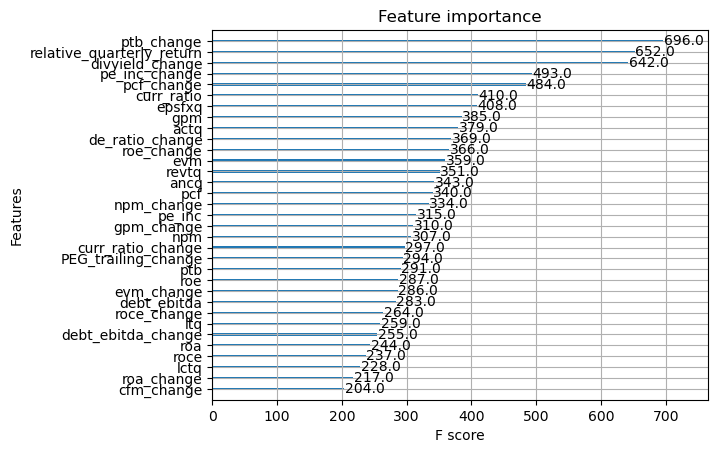

In [1070]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [1071]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)


# Convert test predictions into a DataFrame
predictions_df = pd.DataFrame({"datadate": test_df["datadate"], "tic": test_df["tic"], "true_relative_return": y_test, "pred_rank_score": y_test_pred, 'real_return': test_df['next_prccq_change']})

# Rank stocks within each datadate
predictions_df["pred_rank"] = predictions_df.groupby("datadate")["pred_rank_score"].rank(ascending=False, method="first")
predictions_df["true_rank"] = predictions_df.groupby("datadate")["real_return"].rank(ascending=False, method="first")

#predictions_df = predictions_df.sort_values(by=["datadate", "pred_rank_score"], ascending=[True, True])

# Show the selected stocks for portfolio construction


In [1072]:
predictions_df = predictions_df.sort_values(by=["datadate", "real_return"], ascending=[True, False])

# Filter the DataFrame for rows with that datadate
predictions_df[predictions_df['datadate'] == '2013-03-31'].head(10)

,datadate,tic,true_relative_return,pred_rank_score,real_return,pred_rank,true_rank
1253,2013-03-31,AMD,0.566207,3.109771,0.600000,1.0,1.0
10115,2013-03-31,MU,0.318003,2.106325,0.394627,3.0,2.0
11978,2013-03-31,REGN,0.241016,1.806382,0.274808,5.0,3.0
3228,2013-03-31,CME,0.202977,0.291076,0.236769,16.0,4.0
14621,2013-03-31,WDC,0.200846,1.807529,0.234639,4.0,5.0
9959,2013-03-31,MSFT,0.173863,0.969368,0.207656,9.0,6.0
13004,2013-03-31,STZ,0.121613,2.108390,0.198237,2.0,7.0
2121,2013-03-31,BA,0.159451,0.438029,0.193244,14.0,8.0
10580,2013-03-31,NOC,0.146535,0.927910,0.180328,10.0,9.0
13375,2013-03-31,TGT,0.101628,0.690515,0.168019,12.0,10.0


In [1073]:
def softmax_weighted_return(df, sort_col, target_col, n=10, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=10, largest=True, alpha=0.5):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = predictions_df.groupby('datadate').agg(
    stocks=('real_return', 'size'),
    baseline=('real_return', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = predictions_df.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='pred_rank_score',
        target_col='real_return',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = predictions_df.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='real_return',
        target_col='real_return',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10'] = predictions_df.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='pred_rank_score',
        target_col='real_return',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = predictions_df.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='real_return',
        target_col='real_return',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,63,0.065437,0.386951,0.421077,-0.032015,-0.124256
1,2013-06-30,64,0.059808,0.137158,0.354006,-0.034303,-0.093581
2,2013-09-30,66,0.110123,0.284257,0.412804,-0.078447,-0.106066
3,2013-12-31,66,0.032754,0.170671,0.256265,-0.055002,-0.120828
4,2014-03-31,66,0.039382,0.095635,0.215892,0.005665,-0.098166
5,2014-06-30,67,0.022670,0.097081,0.230542,-0.062381,-0.145873
6,2014-09-30,65,0.054048,0.217064,0.238110,-0.054667,-0.189307
7,2014-12-31,64,0.027150,0.164988,0.206037,-0.088619,-0.152242
8,2015-03-31,65,0.009599,0.052427,0.322730,-0.140916,-0.169087
9,2015-06-30,63,-0.056546,0.100154,0.143413,-0.229023,-0.309548


In [1074]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03360167684373077
Sharpe Ratio of the baseline portfolio: 0.14378314191983466

Mean quarterly return of the top_10 portfolio: 0.21070808734080304
Sharpe Ratio of the top_10 portfolio: 1.5759573856298705

Mean quarterly return of the bottom_10 portfolio: -0.10059762234139379
Sharpe Ratio of the bottom_10 portfolio: -1.6645568923776712



In [1075]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()
